# 1D Offshore Spectrum to Nearshore observations

This version of the code used pytorch

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#handy function for emptying the chached memory in a GPU
#the kernal should be restarted every time this is run
from numba import cuda
cuda.select_device(0)
cuda.close()

### Read in 1d Spectrum

The one dimensional spectrum is stored per timestep in the dataframe, the frequencies don't change.

In [3]:
oneD_Off = pd.read_csv('../data/hindcast_spec.csv', header = 0, index_col = 0, parse_dates = True)
oneD_Off = oneD_Off.apply(pd.to_numeric, errors='coerce')
oneD_Off.index = oneD_Off.index.round('H')

<Axes: >

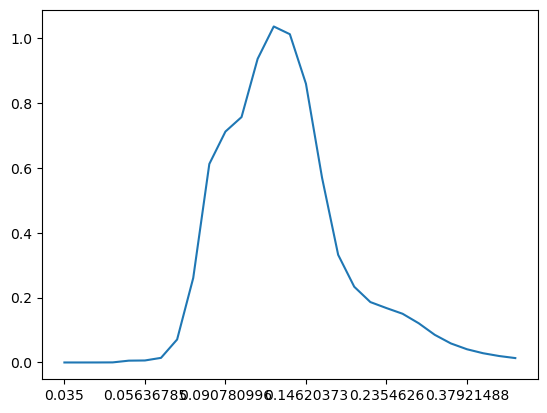

In [4]:
oneD_Off.iloc[300].plot()


We also need to ensure that we have some understanding of direction, so we will read in the offshore wave parameters.

In [5]:
offStats = pd.read_csv("../data/hindcast_offshore_params.csv", index_col = 0 , parse_dates =True )
offStats = offStats.apply(pd.to_numeric, errors='coerce')
offStats.index = offStats.index.round('H')

In [6]:
offStats = offStats.round(2)

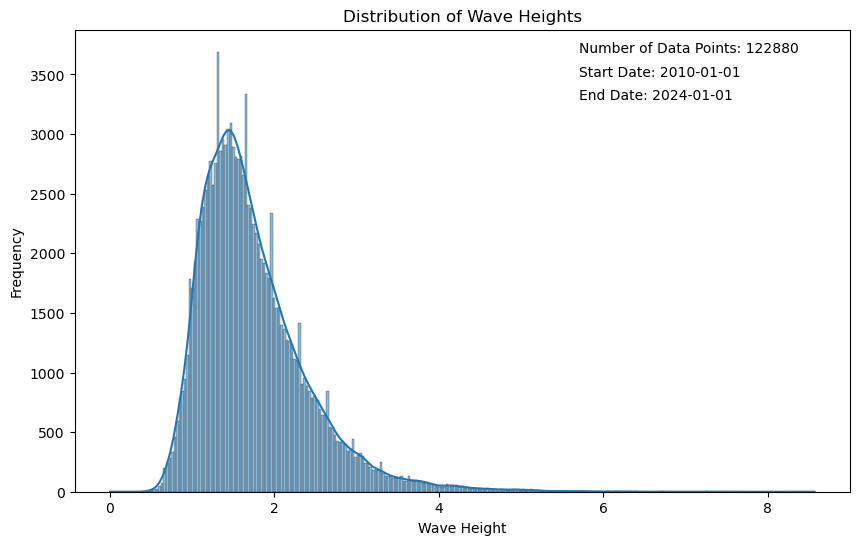

In [7]:
import seaborn as sns

# Create a distribution plot of wave heights
plt.figure(figsize=(10, 6))
sns.histplot(data=offStats, x='hs', kde=True)

# Add notes about the dataset
num_data_points = len(offStats)
start_date = offStats.index[0].strftime('%Y-%m-%d')
end_date = offStats.index[-1].strftime('%Y-%m-%d')
plt.text(0.65, 0.95, f"Number of Data Points: {num_data_points}", transform=plt.gca().transAxes)
plt.text(0.65, 0.9, f"Start Date: {start_date}", transform=plt.gca().transAxes)
plt.text(0.65, 0.85, f"End Date: {end_date}", transform=plt.gca().transAxes)

# Set plot title and labels
plt.title("Distribution of Wave Heights")
plt.xlabel("Wave Height")
plt.ylabel("Frequency")

# Show the plot
plt.show()


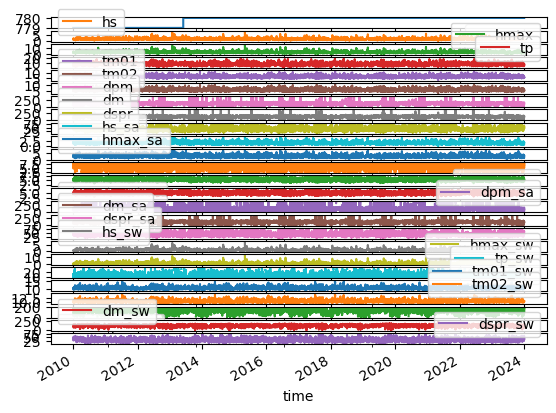

In [8]:
_ = offStats.plot(subplots = True)

In [9]:
start = offStats.sort_index().index[0]
end = offStats.sort_index().index[-1]
len(pd.date_range(start, end, freq='H')) - len(offStats)

-167

In [10]:
len(pd.date_range(start, end, freq='H'))

122713

In [11]:
offStats.drop_duplicates(inplace = True)

## Read in Observational Data

Observational data is available from a number of sources we need to bring them together.

In [12]:
Obs = pd.read_csv('../data/obs_GC.csv', parse_dates = True, index_col = 0)
Obs.columns = ['hs','hmax','tp','tz','dp']
Obs.index = Obs.index - pd.Timedelta(hours=0)

In [13]:
Obs = Obs[Obs['dp']>-1]
Obs = Obs.round(2)

In [14]:
start_date = Obs.index[0].strftime('%Y-%m-%d')
end_date = Obs.index[-1].strftime('%Y-%m-%d')
missingdata = str(len(pd.date_range(Obs.index[0], Obs.index[-1], freq='H')) - len(Obs))
missingdata

'3866'

In [15]:
Obs = Obs.rolling(3).mean()


<Axes: xlabel='Date/Time'>

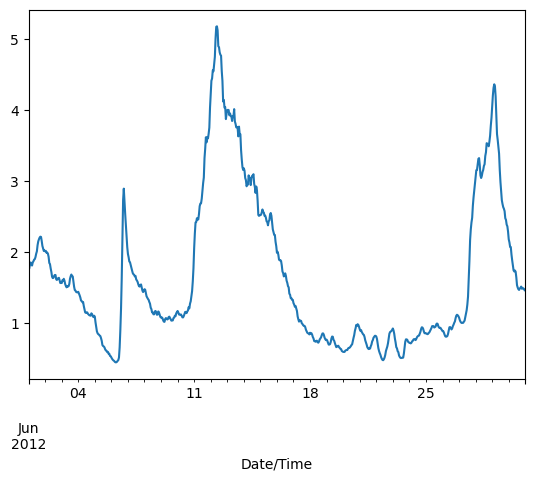

In [16]:
Obs.loc['2012-06':'2012-06'].hs.plot()

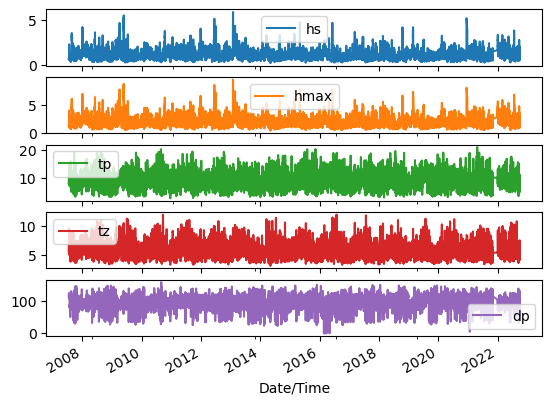

In [17]:
_ = Obs.plot(subplots = True)

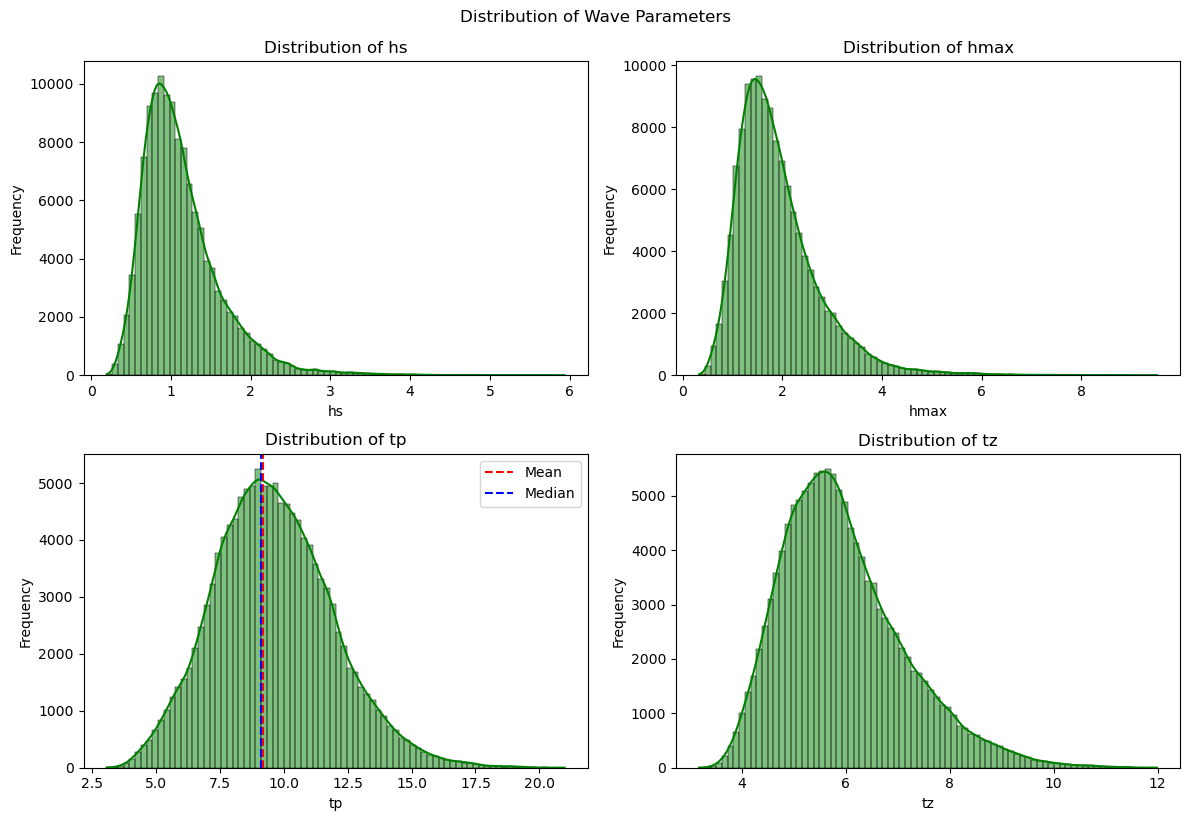

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# Plotting hs
sns.histplot(data=Obs, x='hs', bins=80, kde=True, ax=axes[0, 0], color='green')
axes[0, 0].set_title('Distribution of hs')
axes[0, 0].set_xlabel('hs')
axes[0, 0].set_ylabel('Frequency')

# Plotting hmax
sns.histplot(data=Obs, x='hmax', bins=80, kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title('Distribution of hmax')
axes[0, 1].set_xlabel('hmax')
axes[0, 1].set_ylabel('Frequency')



# Plotting tp
sns.histplot(data=Obs, x='tp', bins=80, kde=True, ax=axes[1, 0], color='green')
axes[1, 0].set_title('Distribution of tp')
axes[1, 0].set_xlabel('tp')
axes[1, 0].set_ylabel('Frequency')

# Add matching parameters from offStats dataset
offStats_tp = offStats['tp']
axes[1, 0].axvline(x=offStats_tp.mean(), color='red', linestyle='--', label='Mean')
axes[1, 0].axvline(x=offStats_tp.median(), color='blue', linestyle='--', label='Median')
axes[1, 0].legend()

# Plotting tz
sns.histplot(data=Obs, x='tz', bins=80, kde=True, ax=axes[1, 1], color='green')
axes[1, 1].set_title('Distribution of tz')
axes[1, 1].set_xlabel('tz')
axes[1, 1].set_ylabel('Frequency')


# Adjusting the layout
plt.tight_layout()
plt.suptitle('Distribution of Wave Parameters', y=1.02)

# Show the plot
plt.show()


In [19]:
start = Obs.sort_index().index[0]
end = Obs.sort_index().index[-1]
len(pd.date_range(start, end, freq='H')) - len(Obs)

3866

In [20]:
new_columns = [column + '_tgt' for column in Obs.columns]
Obs = Obs.rename(columns=dict(zip(Obs.columns, new_columns)))

In [209]:
merged_df = pd.merge(oneD_Off.drop_duplicates(), offStats.drop_duplicates(), left_index=True, right_index=True)
merged_df = pd.merge(merged_df.drop_duplicates(), Obs.drop_duplicates(), left_index=True, right_index=True)

In [210]:
merged_df = merged_df.sort_index()
merged_df.drop_duplicates(inplace = True)
#merged_df = merged_df.dropna()

In [211]:
merged_df.columns

Index(['0.035', '0.0385', '0.042349998', '0.046585', '0.051243503',
       '0.05636785', '0.062004633', '0.068205096', '0.07502561', '0.082528174',
       '0.090780996', '0.099859096', '0.10984501', '0.120829515', '0.13291247',
       '0.14620373', '0.1608241', '0.17690653', '0.19459718', '0.21405691',
       '0.2354626', '0.25900885', '0.28490975', '0.31340075', '0.3447408',
       '0.37921488', '0.4171364', '0.45885003', '0.50473505', 'site', 'hs',
       'hmax', 'tp', 'tm01', 'tm02', 'dpm', 'dm', 'dspr', 'hs_sa', 'hmax_sa',
       'tp_sa', 'tm01_sa', 'tm02_sa', 'dpm_sa', 'dm_sa', 'dspr_sa', 'hs_sw',
       'hmax_sw', 'tp_sw', 'tm01_sw', 'tm02_sw', 'dpm_sw', 'dm_sw', 'dspr_sw',
       'hs_tgt', 'hmax_tgt', 'tp_tgt', 'tz_tgt', 'dp_tgt'],
      dtype='object')

In [212]:
merged_df = merged_df[~merged_df.tm02.isna()]

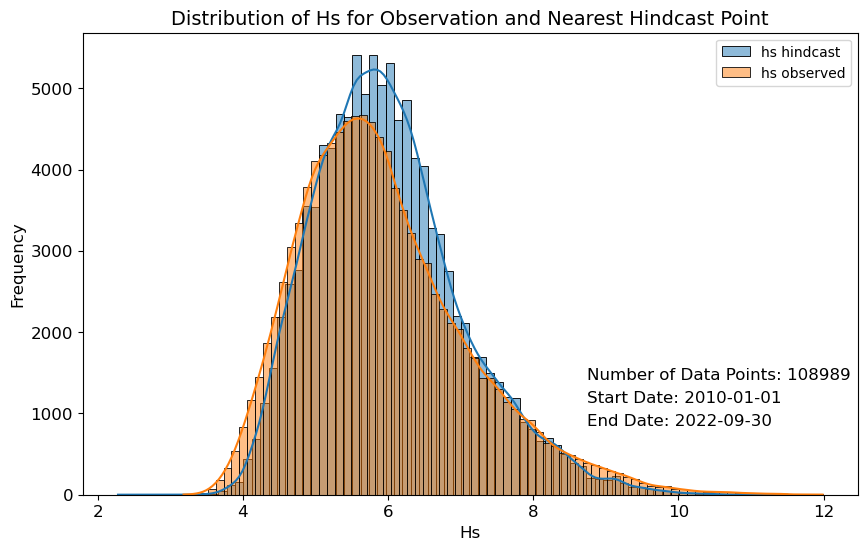

In [213]:
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x='tm02', kde=True, bins=80, label='hs hindcast')
sns.histplot(data=merged_df, x='tz_tgt', kde=True, bins=80, label='hs observed')

# Add notes about the dataset
num_data_points = len(merged_df)
start_date = merged_df.index[0].strftime('%Y-%m-%d')
end_date = merged_df.index[-1].strftime('%Y-%m-%d')
plt.text(0.65, 0.25, f"Number of Data Points: {num_data_points}", transform=plt.gca().transAxes, fontsize=12)
plt.text(0.65, 0.2, f"Start Date: {start_date}", transform=plt.gca().transAxes, fontsize=12)
plt.text(0.65, 0.15, f"End Date: {end_date}", transform=plt.gca().transAxes, fontsize=12)

# Set plot title and labels
plt.title("Distribution of Hs for Observation and Nearest Hindcast Point", fontsize=14)
plt.xlabel("Hs", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Increase the font size of the axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.legend()
plt.show()



In [214]:
mycolumns = ['hs','hs_tgt','hmax','hmax_tgt','tp','tp_tgt','tm02','tz_tgt','dpm','dp_tgt']
sublists = [[mycolumns[i], mycolumns[i+1]] for i in range(0, len(mycolumns), 2)]
sublists

[['hs', 'hs_tgt'],
 ['hmax', 'hmax_tgt'],
 ['tp', 'tp_tgt'],
 ['tm02', 'tz_tgt'],
 ['dpm', 'dp_tgt']]

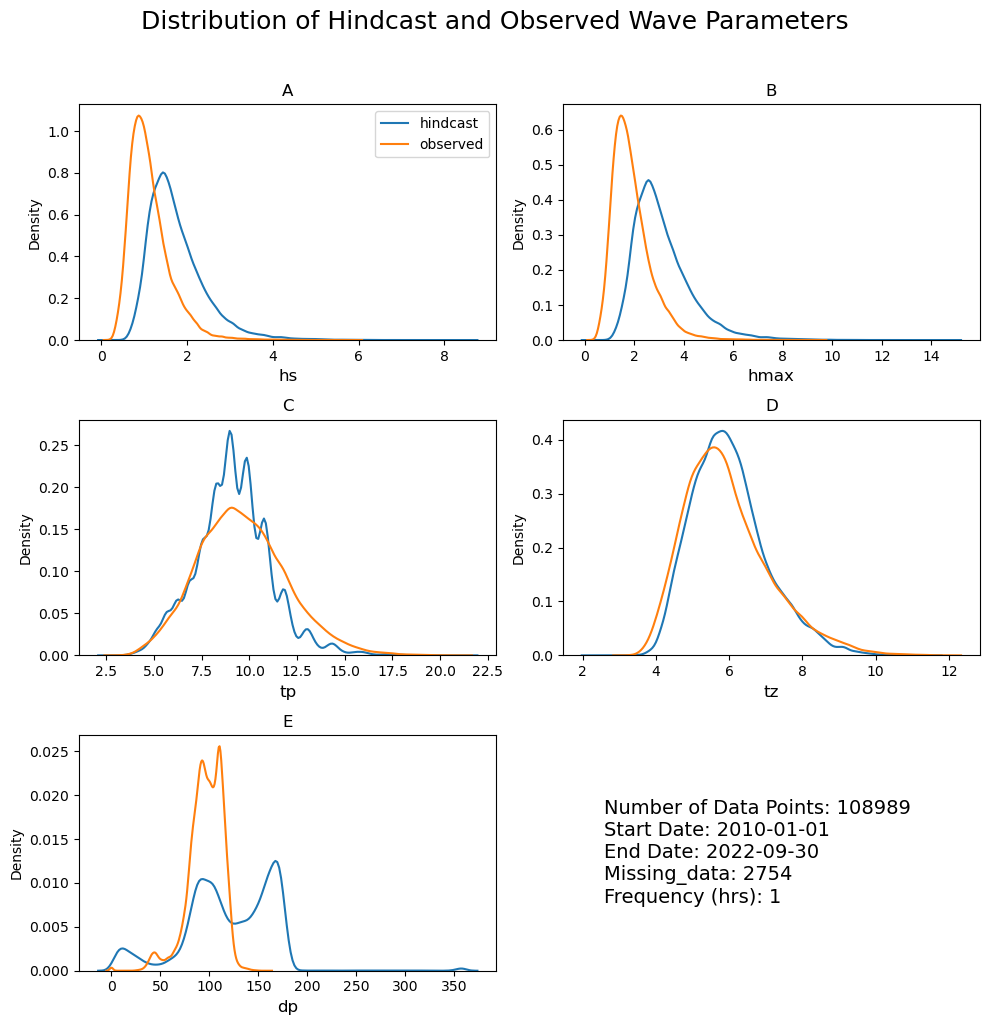

In [215]:
# Calculate the number of rows and columns for subplots
num_rows = 3
num_cols = 2

# Create subplots for distribution plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
plotting_df = merged_df.reset_index(drop=True)

label = ['A','B','C','D','E']

# Iterate over each pair of column names
for i, column in enumerate(sublists):
    row = i // num_cols
    col = i % num_cols
    
    # Create distribution plots for each pair of columns
    sns.kdeplot(data=plotting_df, x=column[0], ax=axes[row, col], label='hindcast')
    sns.kdeplot(data=plotting_df, x=column[1], ax=axes[row, col], label='observed')
    
    # Set titles and labels for each subplot
    #axes[row, col].set_title(f"Distribution of hindcast and observed {column[1].split('_')[0]}")
    axes[row, col].set_xlabel(column[1].split('_')[0], fontsize = 12)
    axes[row, col].set_ylabel("Density")
    axes[row, col].set_title(f"{label[i]}")

axes[2,1].axis('off')
axes[0,0].legend()
#axes[2,1].annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5), xycoords='axes fraction', va='center')

# Add annotation for number of data points and start/end date
num_data_points = len(merged_df)
start_date = merged_df.index[0].strftime('%Y-%m-%d')
end_date = merged_df.index[-1].strftime('%Y-%m-%d')
missingdata = str(len(pd.date_range(merged_df.index[0], merged_df.index[-1], freq='H')) - len(merged_df))
freq = str((merged_df.index[-1]-merged_df.index[-2]).components.hours)
axes[2,1].annotate(f"Number of Data Points: {num_data_points}\nStart Date: {start_date}\nEnd Date: {end_date}\nMissing_data: {missingdata}\nFrequency (hrs): {freq}", xy=(0.1, 0.5), xycoords='axes fraction', va='center', fontsize=14)

plt.suptitle("Distribution of Hindcast and Observed Wave Parameters", y=1.02, fontsize=18)

# Adjust the layout
plt.tight_layout()
#plt.savefig('./Plots/distribution_of_hindcast_and_observed_wave_parameters.png')
# Show the plots
plt.show()


## Feature Engineering

**Time Based**

In [216]:
def feature_engineering_time_series(data):
    # Extracting features from the DateTimeIndex
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Adding cyclic timing features
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    
    # Additional feature engineering steps can be added here
    
    return data

In [217]:
merged_df = feature_engineering_time_series(merged_df)

**Direction Based**

In [218]:
def feature_engineering_wave_direction(data, direction_columns):
    for column in direction_columns:
        # Creating circular features for wave direction
        data[f'{column}_sin'] = np.sin(np.radians(data[column]))
        data[f'{column}_cos'] = np.cos(np.radians(data[column]))
        
        # Removing the original column
        data.drop(column, axis=1, inplace=True)
    
    
    return data

In [219]:
merged_df.columns

Index(['0.035', '0.0385', '0.042349998', '0.046585', '0.051243503',
       '0.05636785', '0.062004633', '0.068205096', '0.07502561', '0.082528174',
       '0.090780996', '0.099859096', '0.10984501', '0.120829515', '0.13291247',
       '0.14620373', '0.1608241', '0.17690653', '0.19459718', '0.21405691',
       '0.2354626', '0.25900885', '0.28490975', '0.31340075', '0.3447408',
       '0.37921488', '0.4171364', '0.45885003', '0.50473505', 'site', 'hs',
       'hmax', 'tp', 'tm01', 'tm02', 'dpm', 'dm', 'dspr', 'hs_sa', 'hmax_sa',
       'tp_sa', 'tm01_sa', 'tm02_sa', 'dpm_sa', 'dm_sa', 'dspr_sa', 'hs_sw',
       'hmax_sw', 'tp_sw', 'tm01_sw', 'tm02_sw', 'dpm_sw', 'dm_sw', 'dspr_sw',
       'hs_tgt', 'hmax_tgt', 'tp_tgt', 'tz_tgt', 'dp_tgt', 'year', 'month',
       'day', 'day_of_week', 'hour', 'hour_sin', 'hour_cos', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos'],
      dtype='object')

In [220]:
dp_col = list(merged_df.columns[merged_df.columns.str.contains('dp_tgt')])
dpm_col = list(merged_df.columns[merged_df.columns.str.contains('dpm')])
dm_col = list(merged_df.columns[merged_df.columns.str.contains('dm')])

In [221]:
merged_df = feature_engineering_wave_direction(merged_df, dpm_col + dm_col + dp_col)

In [222]:
#merged_df['hs+3'] = merged_df['hs'].shift(3)
#merged_df['hs+6'] = merged_df['hs'].shift(6)
#merged_df['hs+12'] = merged_df['hs'].shift(12)
#merged_df['hs+24'] = merged_df['hs_tgt'].shift(24)

In [223]:
merged_df.columns

Index(['0.035', '0.0385', '0.042349998', '0.046585', '0.051243503',
       '0.05636785', '0.062004633', '0.068205096', '0.07502561', '0.082528174',
       '0.090780996', '0.099859096', '0.10984501', '0.120829515', '0.13291247',
       '0.14620373', '0.1608241', '0.17690653', '0.19459718', '0.21405691',
       '0.2354626', '0.25900885', '0.28490975', '0.31340075', '0.3447408',
       '0.37921488', '0.4171364', '0.45885003', '0.50473505', 'site', 'hs',
       'hmax', 'tp', 'tm01', 'tm02', 'dspr', 'hs_sa', 'hmax_sa', 'tp_sa',
       'tm01_sa', 'tm02_sa', 'dspr_sa', 'hs_sw', 'hmax_sw', 'tp_sw', 'tm01_sw',
       'tm02_sw', 'dspr_sw', 'hs_tgt', 'hmax_tgt', 'tp_tgt', 'tz_tgt', 'year',
       'month', 'day', 'day_of_week', 'hour', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'dpm_sin', 'dpm_cos', 'dpm_sa_sin', 'dpm_sa_cos', 'dpm_sw_sin',
       'dpm_sw_cos', 'dm_sin', 'dm_cos', 'dm_sa_sin', 'dm_sa_cos', 'dm_sw_sin',
       'dm_sw_cos', 

In [224]:
merged_df = merged_df.iloc[::2, :] #make 3 hourly

In [225]:
len(merged_df)

54495

In [226]:
print(merged_df.index[-1])

2022-09-30 23:00:00


In [227]:
#ind_data = merged_df["2020-01-01":]
#merged_df  = merged_df[:"2020-01-01"]


ind_data = merged_df["2022-01-01":]
merged_df  = merged_df[:"2022-01-01"]

In [228]:
len(ind_data)

3243

## Selecting Training Data

In [229]:
merged_df.columns

Index(['0.035', '0.0385', '0.042349998', '0.046585', '0.051243503',
       '0.05636785', '0.062004633', '0.068205096', '0.07502561', '0.082528174',
       '0.090780996', '0.099859096', '0.10984501', '0.120829515', '0.13291247',
       '0.14620373', '0.1608241', '0.17690653', '0.19459718', '0.21405691',
       '0.2354626', '0.25900885', '0.28490975', '0.31340075', '0.3447408',
       '0.37921488', '0.4171364', '0.45885003', '0.50473505', 'site', 'hs',
       'hmax', 'tp', 'tm01', 'tm02', 'dspr', 'hs_sa', 'hmax_sa', 'tp_sa',
       'tm01_sa', 'tm02_sa', 'dspr_sa', 'hs_sw', 'hmax_sw', 'tp_sw', 'tm01_sw',
       'tm02_sw', 'dspr_sw', 'hs_tgt', 'hmax_tgt', 'tp_tgt', 'tz_tgt', 'year',
       'month', 'day', 'day_of_week', 'hour', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'dpm_sin', 'dpm_cos', 'dpm_sa_sin', 'dpm_sa_cos', 'dpm_sw_sin',
       'dpm_sw_cos', 'dm_sin', 'dm_cos', 'dm_sa_sin', 'dm_sa_cos', 'dm_sw_sin',
       'dm_sw_cos', 

In [230]:
features_col = ['0.035', '0.0385', '0.042349998', '0.046585', '0.051243503',
       '0.05636785', '0.062004633', '0.068205096', '0.07502561', '0.082528174',
       '0.090780996', '0.099859096', '0.10984501', '0.120829515', '0.13291247',
       '0.14620373', '0.1608241', '0.17690653', '0.19459718', '0.21405691',
       '0.2354626', '0.25900885', '0.28490975', '0.31340075', '0.3447408',
       '0.37921488', '0.4171364',  '0.45885003', '0.50473505','tm02','hour','dpm_sin', 'dpm_cos']
#'dm_sa_sin','dm_sw_sin','hour_sin','hs','hs_sw','hs_sa','tp'

In [231]:
labels_col = ['dp_tgt_sin','dp_tgt_cos']

In [232]:
fdata = merged_df[features_col+labels_col].dropna()

In [233]:
features = fdata[features_col].values
labels = fdata[labels_col].values

In [234]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [235]:
from sklearn.model_selection import TimeSeriesSplit

In [236]:
T = 13                   #Number of timesteps to look while predicting
D = features.shape[1]   #Dimensionality of the input
N = len(features) - T
print(f'Dimensions are {T} × {D} × {N}')

Dimensions are 13 × 33 × 51252


In [237]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#Train size: 80% of the total data size
train_size = int(len(features) * 0.85)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(features[:train_size + T - 1])
features = scaler.transform(features)


In [238]:
# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 2))

for t in range(train_size):
  X_train[t, :, :] = features[t:t+T]
  y_train[t] = (labels[t+T])

In [239]:
# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 2))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = features[t:t+T]
  y_test[i] = (labels[t+T])

## Pytorch Data Preparation

In [240]:
import torch
import torch.nn as nn

In [241]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [242]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

## Construct simple LTSM

In [243]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    
    return out


For the number of hidden layers, the recommendation is 1 for simple problems and 2 for complex features. As our time series is slightly complex, I will be using 2.

Considering our training data size of 25,000> and input dimensionality; it's better to use hidden size at least 100 and at most 1000. 512 yielded good result.

In [244]:
model = LSTM(D, 72, 8, 2)
model.to(device)

LSTM(
  (rnn): LSTM(33, 72, num_layers=8, batch_first=True)
  (fc): Linear(in_features=72, out_features=2, bias=True)
)

In [245]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    model.load_state_dict(torch.load(filename))

# Training
def train(model,
          learning_rate,
          X_train,
          y_train,
          X_test,
          y_test,
          epochs=250):

  # Loss and optimizer
  criterion = nn.MSELoss()
  #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  loser = 1
  for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backpropagation
    loss.backward()
    optimizer.step()

    #Train loss
    train_losses[epoch] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[epoch] = test_loss.item()
    
    
    if (epoch + 1) % 60 == 0:
      print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')
      checkpoint(model, "best_model_dp.pth")
      #evaluate
      if loser > test_loss.item():
        print(f'current test best = {loser:.3f}, current test loss is: {test_loss.item():.3f}')
        print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')
        loser = test_loss.item()
        continue
      else:
        break
  return train_losses, test_losses

To do: 
- We need to add better early stopping approach that works on a per epoch and is wise enough to give 5 or more epochs before using the best one
- Need to test alternative learning rates, results seem to vary wildly depending on the learning rate.

## Train the Model

In [246]:

# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_losses, test_losses = train(model,
                                    0.01,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=600)

At epoch 60 of 600, Train Loss: 0.044, Test Loss: 0.039
current test best = 1.000, current test loss is: 0.039
At epoch 60 of 600, Train Loss: 0.044, Test Loss: 0.039
At epoch 120 of 600, Train Loss: 0.017, Test Loss: 0.016
current test best = 0.039, current test loss is: 0.016
At epoch 120 of 600, Train Loss: 0.017, Test Loss: 0.016
At epoch 180 of 600, Train Loss: 0.013, Test Loss: 0.018


Find the best model from the training and load that in over the top of the latest one!

In [247]:
resume(model, "best_model_dp.pth")

In [248]:
#torch.save(model.state_dict(), "hs_ltsm_spec.sav")

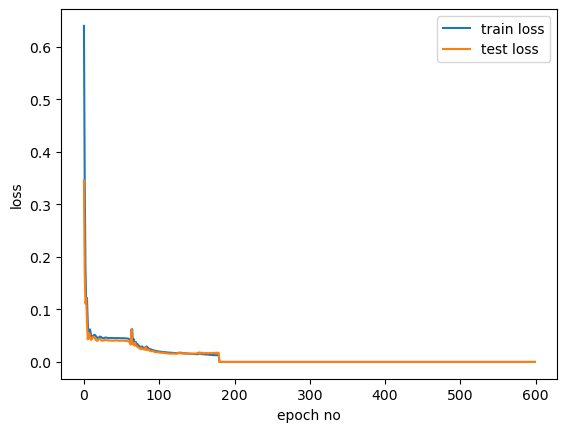

In [249]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

## Assess performance against test data

In [250]:

#Checking one-step prediction performance of the model
test_target = y_test.cpu().detach().numpy()
test_predictions = []

for i in range(len(test_target)):
  input_ = X_test[i].reshape(1, T, D)
  p = model(input_)[:,0].item(), model(input_)[:,1].item()

  # update the predictions list
  test_predictions.append(p)
  

In [251]:
import math
def get_direction(sin, cos):
    direction = math.atan2(sin, cos)
    direction = math.degrees(direction)  # Convert from radians to degrees
    direction = (direction + 360) % 360  # Normalize to 0-360
    return direction

In [252]:

plot_len = len(test_predictions)
plot_df = merged_df[labels_col].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df[['prediction_sin','prediction_cos']] = test_predictions
plot_df['pred_dp'] = plot_df.apply(lambda row: get_direction(row['prediction_sin'], row['prediction_cos']), axis=1)
plot_df['dp'] = plot_df.apply(lambda row: get_direction(row['dp_tgt_sin'], row['dp_tgt_cos']), axis=1)
plot_df.head(5)

,dp_tgt_sin,dp_tgt_cos,prediction_sin,prediction_cos,pred_dp,dp
2020-01-18 00:00:00,0.995800,0.091560,0.961223,0.195969,78.476756,84.746667
2020-01-18 02:00:00,0.984030,0.178001,0.962438,0.190006,78.832171,79.746667
2020-01-18 04:00:00,0.963225,0.268696,0.961637,0.194245,78.580228,74.413333
2020-01-18 06:00:00,0.930928,0.365202,0.962773,0.191044,78.776544,68.580000
2020-01-18 08:00:00,0.945025,0.326998,0.968774,0.166212,80.264608,70.913333


In [253]:
plot_df['pred_dp'].max()

118.85838200484517

Text(0, 0.5, 'Hs (m)')

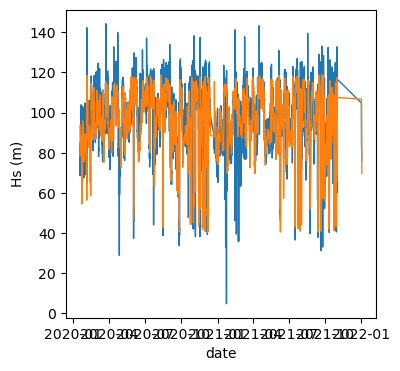

In [254]:
fig = plt.figure(figsize = (4, 4))
plt.plot(plot_df['dp'], label='Actual Hs', linewidth=1)
plt.plot(plot_df['pred_dp'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('Hs (m)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


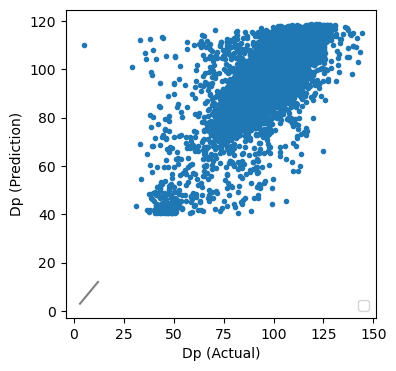

In [255]:
fig = plt.figure(figsize = (4, 4))
plt.plot([3,12], [3,12], color = 'grey')
plt.plot(plot_df['dp'].values, plot_df['pred_dp'], '.')
plt.xlabel('Dp (Actual)')
plt.ylabel('Dp (Prediction)')
plt.legend(loc='lower right')

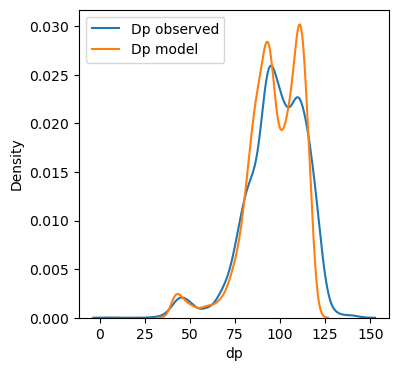

In [256]:
plt.figure(figsize=(4, 4))
sns.kdeplot(data=plot_df, x='dp', label='Dp observed')
sns.kdeplot(data=plot_df, x='pred_dp', label='Dp model')
plt.legend()

## Test against independent data

The training dataset has gaps due to observations, so for the independent dataset we will gather everything to get a better understanding of performance.

In [259]:
features_ind = scaler.transform(ind_data[features_col].values)

In [260]:
N = len(ind_data) - T
#need to remove this step.... and adjust code below
ind_size = T

# Preparing X_test and y_test
X_ind = np.zeros((N - ind_size, T, D))

for i in range(N - ind_size):
  t = i + ind_size
  X_ind[i, :, :] = features_ind[t:t+T]


In [261]:
X_ind = torch.from_numpy(X_ind.astype(np.float32))

X_ind = X_ind.to(device)

In [262]:
ind_predictions = []
for i in range(len(X_ind)):
  input_ = X_ind[i].reshape(1, T, D)
  p = model(input_)[0,0].item(), model(input_)[:,1].item()

  # update the predictions list
  ind_predictions.append(p)

In [263]:
len(ind_predictions)

3217

In [264]:

plot_len = len(ind_predictions)
plot_df = ind_data[labels_col].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df[['prediction_sin','prediction_cos']] = ind_predictions
plot_df['pred_dp'] = plot_df.apply(lambda row: get_direction(row['prediction_sin'], row['prediction_cos']), axis=1)
plot_df['dp'] = plot_df.apply(lambda row: get_direction(row['dp_tgt_sin'], row['dp_tgt_cos']), axis=1)
#plot_df['prediction'] = np.round(ind_predictions, 2)
#plot_df['prediction'] = plot_df['prediction'].shift(1)
plot_df.dropna(inplace = True)
plot_df.head(5)

,dp_tgt_sin,dp_tgt_cos,prediction_sin,prediction_cos,pred_dp,dp
2022-01-03 03:00:00,0.971301,0.237855,0.932214,0.297997,72.272710,76.240000
2022-01-03 05:00:00,0.987888,0.155170,0.909332,0.360011,68.400999,81.073333
2022-01-03 07:00:00,0.993386,0.114822,0.838715,0.496365,59.382302,83.406667
2022-01-03 09:00:00,0.995518,0.094572,0.797291,0.554694,55.172740,84.573333
2022-01-03 11:00:00,0.994037,0.109040,0.788996,0.567797,54.259521,83.740000


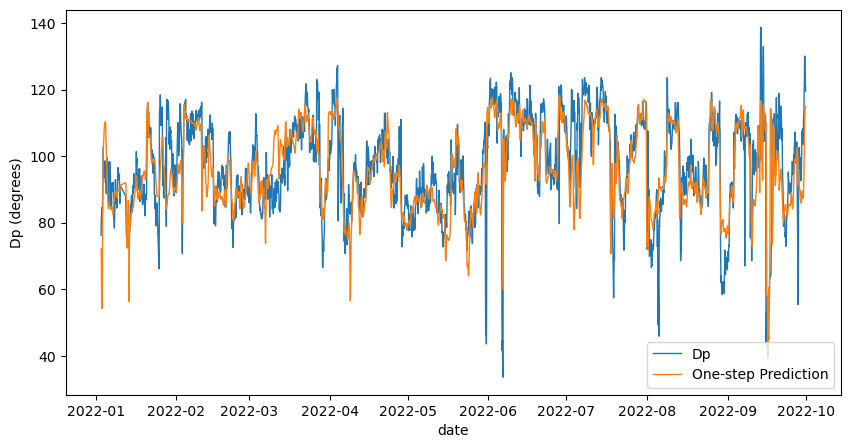

In [265]:
fig = plt.figure(figsize = (10, 5))
plt.plot(plot_df['dp'], label='Dp', linewidth=1)
plt.plot(plot_df['pred_dp'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('Dp (degrees)')
plt.legend(loc='lower right')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


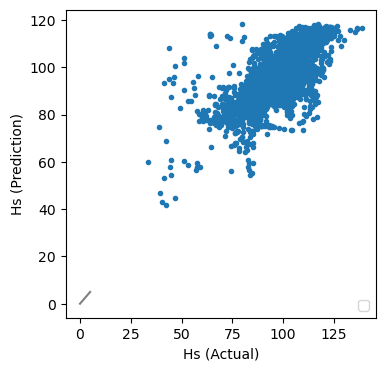

In [266]:
fig = plt.figure(figsize = (4, 4))
plt.plot([0,5], [0,5], color = 'grey')
plt.plot(plot_df['dp'].values, plot_df['pred_dp'], '.')
plt.xlabel('Hs (Actual)')
plt.ylabel('Hs (Prediction)')
plt.legend(loc='lower right')

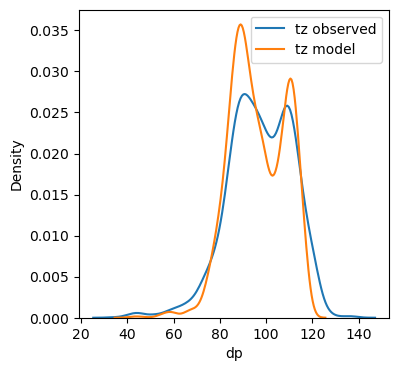

In [267]:
plt.figure(figsize=(4, 4))
sns.kdeplot(data=plot_df, x='dp', label='tz observed')
sns.kdeplot(data=plot_df, x='pred_dp', label='tz model')
plt.legend()

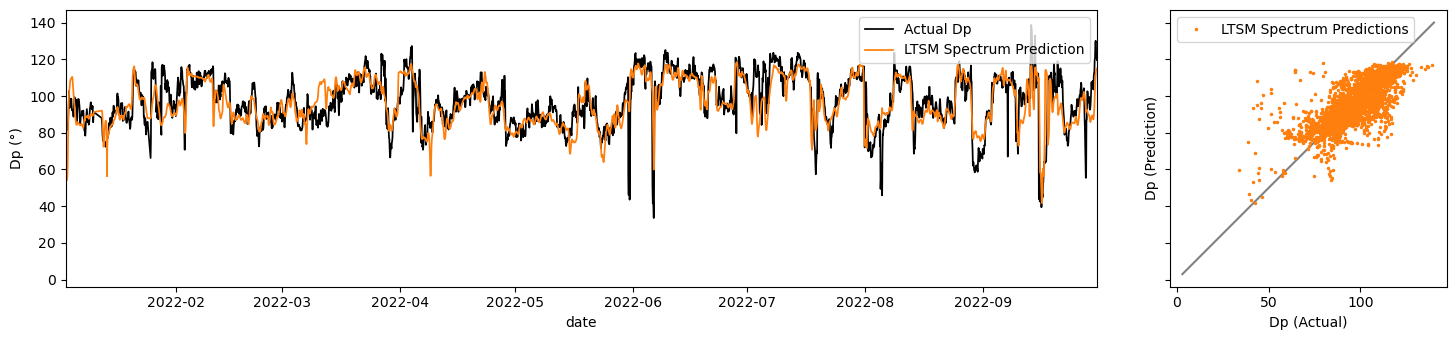

In [268]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3.5), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)  # Increase the width of the figure, adjust the width ratios, and share the y-axis

start = plot_df.loc['2022-01':].index[0]
end = ind_data.index[-1]

# Line timeseries plot
ax1.plot(plot_df['dp'], label='Actual Dp', linewidth=1.25, color = 'k')
ax1.plot(plot_df['pred_dp'], label='LTSM Spectrum Prediction', linewidth=1.25, color = 'tab:orange')
ax1.set_xlabel('date')
ax1.set_ylabel('Dp (°)')
ax1.legend(loc='upper right')

# Scatter plot
ax2.plot([3, 140], [3, 140], color='grey')
ax2.plot(plot_df['dp'].values, plot_df['pred_dp'], '.', markersize=3, label='LTSM Spectrum Predictions', color = 'tab:orange')
ax2.set_xlabel('Dp (Actual)')
ax2.set_ylabel('Dp (Prediction)')
ax2.legend(loc='upper left')
ax2.set_aspect('equal')  # Set aspect ratio to 'equal'

ax1.set_xlim(left=start, right=end)

plt.tight_layout()
#plt.savefig('./plots/independent_data_prediction_spec_dp.png', dpi=300, bbox_inches='tight')


In [270]:
plot_df.to_csv('../data/LSTM_1DSpec_predictions_dp.csv')

In [269]:
import cal_stats
cal_stats.all_stats(plot_df['dp'].values, plot_df['pred_dp'].values.flatten())

{'Bias': 1.22,
 'Root Mean Squared Error': 9.29,
 'Scatter Index': 9.6,
 'Coefficient of Determination': 0.57,
 'Coefficient of Efficiency': 0.4,
 'Correlation Coefficient': 0.76,
 'Index of Agreement': 0.86}

In [428]:
import cal_stats
cal_stats.all_stats(plot_df['dp'].loc[start:].values, plot_df['pred_dp'].loc[start:].values.flatten())

{'Bias': 1.47,
 'Root Mean Squared Error': 9.26,
 'Scatter Index': 9.5,
 'Coefficient of Determination': 0.58,
 'Coefficient of Efficiency': 0.33,
 'Correlation Coefficient': 0.76,
 'Index of Agreement': 0.86}

# LTSM Total Conditions

In [209]:
features_col = ['hs','tp','tm02','dm_sin','dpm_sin', 'dpm_cos']

In [210]:
labels_col = ['dp_tgt_sin', 'dp_tgt_cos']

In [211]:
features = merged_df[features_col+labels_col].dropna()[features_col].values
labels = merged_df[features_col+labels_col].dropna()[labels_col].values

In [212]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [213]:
from sklearn.model_selection import TimeSeriesSplit

In [214]:
T = 13                   #Number of timesteps to look while predicting
D = features.shape[1]   #Dimensionality of the input
N = len(features) - T
print(f'Dimensions are {T} × {D} × {N}')

Dimensions are 13 × 6 × 102515


In [215]:
from sklearn.preprocessing import StandardScaler
#Train size: 80% of the total data size
train_size = int(len(features) * 0.80)

# Normalization of the inputs
#scaler = StandardScaler()
#scaler.fit(features[:train_size + T - 1])
#features = scaler.transform(features)

In [217]:
# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 2))

for t in range(train_size):
  X_train[t, :, :] = features[t:t+T]
  y_train[t] = (labels[t+T])

In [218]:
# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 2))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = features[t:t+T]
  y_test[i] = (labels[t+T])

## Pytorch Data Preparation

In [219]:
import torch
import torch.nn as nn

In [220]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [221]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

## Construct simple LTSM

In [222]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    
    return out


For the number of hidden layers, the recommendation is 1 for simple problems and 2 for complex features. As our time series is slightly complex, I will be using 2.

Considering our training data size of 25,000> and input dimensionality; it's better to use hidden size at least 100 and at most 1000. 512 yielded good result.

In [226]:
#model = LSTM(D, 64, 6, 1)
model = LSTM(D, 34, 6, 2)
model.to(device)

LSTM(
  (rnn): LSTM(6, 34, num_layers=6, batch_first=True)
  (fc): Linear(in_features=34, out_features=2, bias=True)
)

In [227]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    model.load_state_dict(torch.load(filename))

# Training
def train(model,
          learning_rate,
          X_train,
          y_train,
          X_test,
          y_test,
          epochs=250):

  # Loss and optimizer
  criterion = nn.MSELoss()
  #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  loser = 1
  for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backpropagation
    loss.backward()
    optimizer.step()

    #Train loss
    train_losses[epoch] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[epoch] = test_loss.item()
    
    
    if (epoch + 1) % 75 == 0:
      print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')
      checkpoint(model, "best_model_total_cond_dp.pth")
      #evaluate
      if loser > test_loss.item():
        print(f'current test best = {loser:.3f}, current test loss is: {test_loss.item():.3f}')
        print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')
        loser = test_loss.item()
        continue
      else:
        break
  return train_losses, test_losses

To do: 
- We need to add better early stopping approach that works on a per epoch and is wise enough to give 5 or more epochs before using the best one
- Need to test alternative learning rates, results seem to vary wildly depending on the learning rate.

## Train the Model

In [228]:

# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_losses, test_losses = train(model,
                                    0.01,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=600)

At epoch 75 of 600, Train Loss: 0.044, Test Loss: 0.045
current test best = 1.000, current test loss is: 0.045
At epoch 75 of 600, Train Loss: 0.044, Test Loss: 0.045
At epoch 150 of 600, Train Loss: 0.021, Test Loss: 0.022
current test best = 0.045, current test loss is: 0.022
At epoch 150 of 600, Train Loss: 0.021, Test Loss: 0.022
At epoch 225 of 600, Train Loss: 0.019, Test Loss: 0.019
current test best = 0.022, current test loss is: 0.019
At epoch 225 of 600, Train Loss: 0.019, Test Loss: 0.019
At epoch 300 of 600, Train Loss: 0.019, Test Loss: 0.019
current test best = 0.019, current test loss is: 0.019
At epoch 300 of 600, Train Loss: 0.019, Test Loss: 0.019
At epoch 375 of 600, Train Loss: 0.018, Test Loss: 0.019


Find the best model from the training and load that in over the top of the latest one!

In [229]:
resume(model, "best_model_total_cond_dp.pth")

In [230]:
#torch.save(model.state_dict(), "best_model_total_cond.sav")

In [231]:
#loading model
#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval()

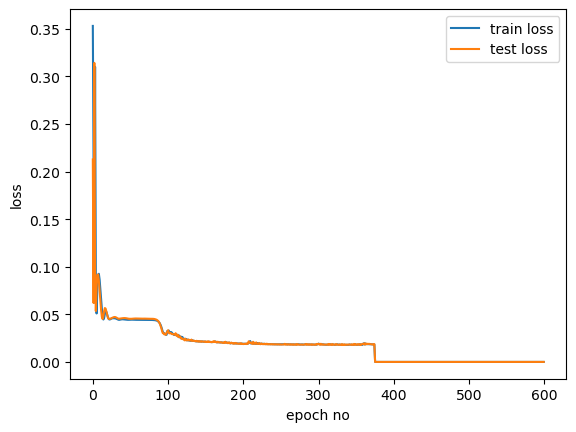

In [232]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()
     

We are seeing a good fit. However, it seems the model is not good at predicting rapid increase/decrease in a short-period of time or picking out the extremes.

## Test against independent data

The training dataset has gaps due to observations, so for the independent dataset we will gather everything to get a better understanding of performance.

In [238]:
features_ind = ind_data[features_col].values

In [239]:
N = len(ind_data) - T
#need to remove this step.... and adjust code below
ind_size = T

# Preparing X_test and y_test
X_ind = np.zeros((N - ind_size, T, D))

for i in range(N - ind_size):
  t = i + ind_size
  X_ind[i, :, :] = features_ind[t:t+T]


In [240]:
X_ind = torch.from_numpy(X_ind.astype(np.float32))

X_ind = X_ind.to(device)

In [241]:
X_ind[i].shape

torch.Size([13, 6])

In [242]:
ind_predictions = []
for i in range(len(X_ind)):
  input_ = X_ind[i].reshape(1, T, D)
  p = model(input_)[:,0].item(), model(input_)[:,1].item()

  # update the predictions list
  ind_predictions.append(p)

In [243]:
len(ind_predictions)

6459

In [244]:

plot_len = len(ind_predictions)
plot_df = ind_data[labels_col].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df[['prediction_sin','prediction_cos']] = ind_predictions
plot_df['pred_dp'] = plot_df.apply(lambda row: get_direction(row['prediction_sin'], row['prediction_cos']), axis=1)
plot_df['dp'] = plot_df.apply(lambda row: get_direction(row['dp_tgt_sin'], row['dp_tgt_cos']), axis=1)
plot_df.dropna(inplace = True)
plot_df.head(5)

,dp_tgt_sin,dp_tgt_cos,prediction_sin,prediction_cos,pred_dp,dp
2022-01-02 01:00:00,0.969188,0.246322,0.930205,0.232348,75.975561,75.740000
2022-01-02 02:00:00,0.967001,0.254771,0.928758,0.235536,75.769613,75.240000
2022-01-02 03:00:00,0.968467,0.249141,0.929385,0.234105,75.861779,75.573333
2022-01-02 04:00:00,0.967001,0.254771,0.929821,0.233100,75.926348,75.240000
2022-01-02 05:00:00,0.971988,0.235029,0.930206,0.232205,75.983837,76.406667


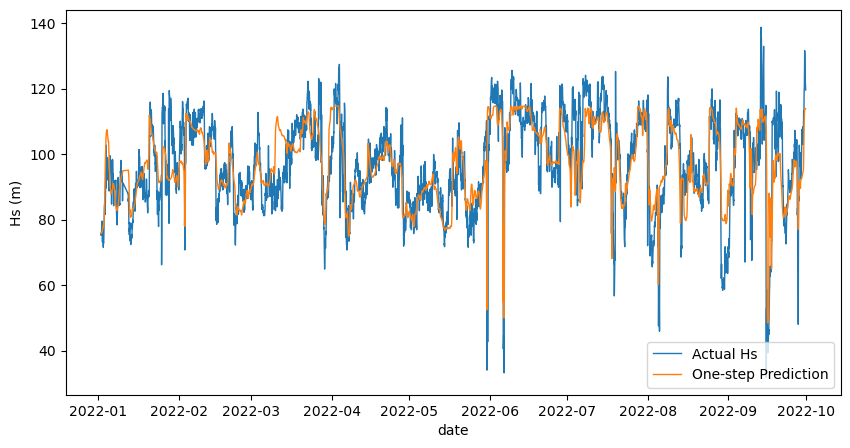

In [245]:
fig = plt.figure(figsize = (10, 5))
plt.plot(plot_df['dp'], label='Actual Hs', linewidth=1)
plt.plot(plot_df['pred_dp'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('Hs (m)')
plt.legend(loc='lower right')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


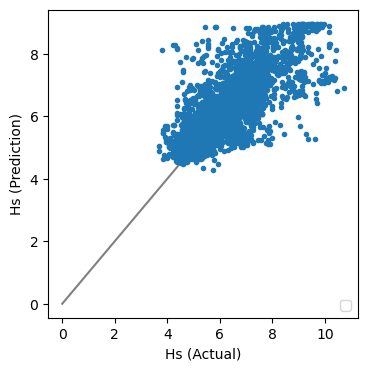

In [230]:
fig = plt.figure(figsize = (4, 4))
plt.plot([0,5], [0,5], color = 'grey')
plt.plot(plot_df[labels_col].values, plot_df['prediction'], '.')
plt.xlabel('Hs (Actual)')
plt.ylabel('Hs (Prediction)')
plt.legend(loc='lower right')

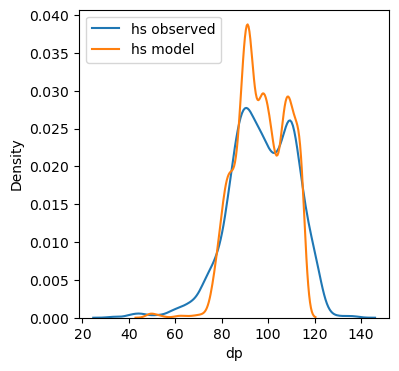

In [246]:
plt.figure(figsize=(4, 4))
sns.kdeplot(data=plot_df, x='dp', label='hs observed')
sns.kdeplot(data=plot_df, x='pred_dp', label='hs model')
plt.legend()

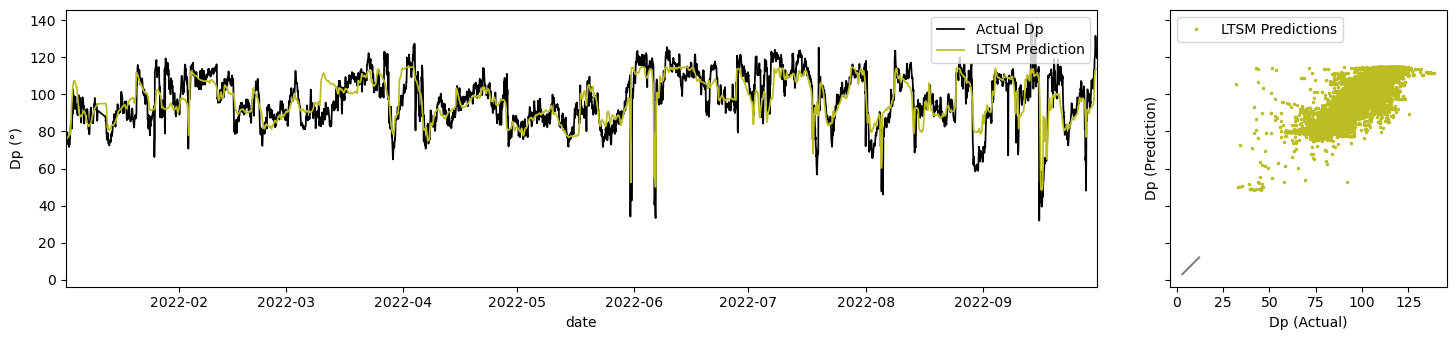

In [247]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3.5), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)  # Increase the width of the figure, adjust the width ratios, and share the y-axis

start = plot_df.loc['2022-01':].index[0]
end = ind_data.index[-1]

# Line timeseries plot
ax1.plot(plot_df['dp'], label='Actual Dp', linewidth=1.25, color = 'k')
ax1.plot(plot_df['pred_dp'], label='LTSM Prediction', linewidth=1.25, color = 'tab:olive')
ax1.set_xlabel('date')
ax1.set_ylabel('Dp (°)')
ax1.legend(loc='upper right')

# Scatter plot
ax2.plot([3, 12], [3, 12], color='grey')
ax2.plot(plot_df['dp'].values, plot_df['pred_dp'], '.', markersize=3, label='LTSM Predictions', color = 'tab:olive')
ax2.set_xlabel('Dp (Actual)')
ax2.set_ylabel('Dp (Prediction)')
ax2.legend(loc='upper left')
ax2.set_aspect('equal')  # Set aspect ratio to 'equal'

ax1.set_xlim(left=start, right=end)

plt.tight_layout()
plt.savefig('./plots/independent_data_prediction_ltsm_total_dp.png', dpi=300, bbox_inches='tight')


In [248]:
import cal_stats
cal_stats.all_stats(plot_df['pred_dp'].loc[start:].values, plot_df['dp'].loc[start:].values.flatten())

{'Bias': -0.23,
 'Root Mean Squared Error': 8.78,
 'Scatter Index': 9.0,
 'Coefficient of Determination': 0.61,
 'Coefficient of Efficiency': 0.61,
 'Correlation Coefficient': 0.78,
 'Index of Agreement': 0.87}

# LTSM Partitioned

In [282]:
features_col = ['hs','tp','tm02',
                'hs_sa', 'tm02_sa',
                'hs_sw','tm02_sw',
                'dpm_cos','dpm_sin','dm_sa_sin', 'dm_sw_sin']

In [283]:
labels_col = ['dp_tgt_sin', 'dp_tgt_cos']

In [284]:
features = merged_df[features_col+labels_col].dropna()[features_col].values
labels = merged_df[features_col+labels_col].dropna()[labels_col].values

In [285]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [286]:
from sklearn.model_selection import TimeSeriesSplit

In [287]:
T = 13                   #Number of timesteps to look while predicting
D = features.shape[1]   #Dimensionality of the input
N = len(features) - T
print(f'Dimensions are {T} × {D} × {N}')

Dimensions are 13 × 11 × 51252


In [288]:
from sklearn.preprocessing import StandardScaler
#Train size: 80% of the total data size
train_size = int(len(features) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(features[:train_size + T - 1])
features = scaler.transform(features)

In [289]:
# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 2))

for t in range(train_size):
  X_train[t, :, :] = features[t:t+T]
  y_train[t] = (labels[t+T])

In [290]:
# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 2))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = features[t:t+T]
  y_test[i] = (labels[t+T])

## Pytorch Data Preparation

In [291]:
import torch
import torch.nn as nn

In [292]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [293]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

## Construct simple LTSM

In [294]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    
    return out


For the number of hidden layers, the recommendation is 1 for simple problems and 2 for complex features. As our time series is slightly complex, I will be using 2.

Considering our training data size of 25,000> and input dimensionality; it's better to use hidden size at least 100 and at most 1000. 512 yielded good result.

In [295]:
model = LSTM(D, 64, 6, 2)
model.to(device)

LSTM(
  (rnn): LSTM(11, 64, num_layers=6, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [297]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    model.load_state_dict(torch.load(filename))

# Training
def train(model,
          learning_rate,
          X_train,
          y_train,
          X_test,
          y_test,
          epochs=250):

  # Loss and optimizer
  criterion = nn.MSELoss()
  #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  loser = 1
  for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backpropagation
    loss.backward()
    optimizer.step()

    #Train loss
    train_losses[epoch] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[epoch] = test_loss.item()
    
    
    if (epoch + 1) % 75 == 0:
      print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')
      checkpoint(model, "best_model_part_dp.pth")
      #evaluate
      if loser > test_loss.item():
        print(f'current test best = {loser:.3f}, current test loss is: {test_loss.item():.3f}')
        print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')
        loser = test_loss.item()
        continue
      else:
        break
  return train_losses, test_losses

To do: 
- We need to add better early stopping approach that works on a per epoch and is wise enough to give 5 or more epochs before using the best one
- Need to test alternative learning rates, results seem to vary wildly depending on the learning rate.

## Train the Model

In [298]:

# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_losses, test_losses = train(model,
                                    0.001,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=600)

At epoch 75 of 600, Train Loss: 0.044, Test Loss: 0.044
current test best = 1.000, current test loss is: 0.044
At epoch 75 of 600, Train Loss: 0.044, Test Loss: 0.044
At epoch 150 of 600, Train Loss: 0.019, Test Loss: 0.019
current test best = 0.044, current test loss is: 0.019
At epoch 150 of 600, Train Loss: 0.019, Test Loss: 0.019
At epoch 225 of 600, Train Loss: 0.017, Test Loss: 0.017
current test best = 0.019, current test loss is: 0.017
At epoch 225 of 600, Train Loss: 0.017, Test Loss: 0.017
At epoch 300 of 600, Train Loss: 0.016, Test Loss: 0.017


In [299]:
resume(model, "best_model_part_dp.pth")

In [300]:
#torch.save(model.state_dict(), "best_model_total_cond.sav")

In [301]:
#loading model
#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval()

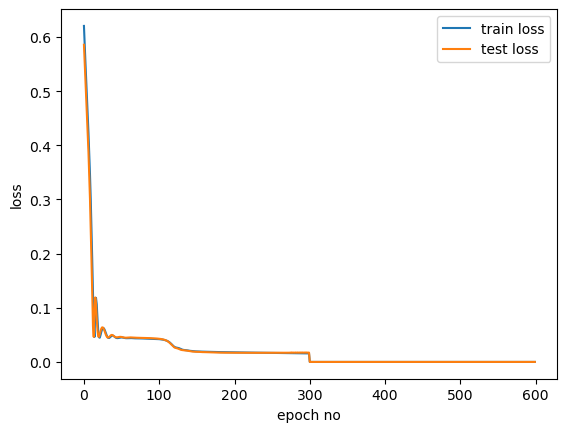

In [302]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()
     

We are seeing a good fit. However, it seems the model is not good at predicting rapid increase/decrease in a short-period of time or picking out the extremes.

## Test against independent data

The training dataset has gaps due to observations, so for the independent dataset we will gather everything to get a better understanding of performance.

In [303]:
features_ind = scaler.transform(ind_data[features_col].values)

In [304]:
N = len(ind_data) - T
#need to remove this step.... and adjust code below
ind_size = T

# Preparing X_test and y_test
X_ind = np.zeros((N - ind_size, T, D))

for i in range(N - ind_size):
  t = i + ind_size
  X_ind[i, :, :] = features_ind[t:t+T]


In [305]:
X_ind = torch.from_numpy(X_ind.astype(np.float32))

X_ind = X_ind.to(device)

In [306]:
X_ind[i].shape

torch.Size([13, 11])

In [307]:
ind_predictions = []
for i in range(len(X_ind)):
  input_ = X_ind[i].reshape(1, T, D)
  p = model(input_)[0,0].item(), model(input_)[0,1].item()

  # update the predictions list
  ind_predictions.append(p)

In [308]:
len(ind_predictions)

3217

In [309]:

plot_len = len(ind_predictions)
plot_df = ind_data[labels_col].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df[['prediction_sin','prediction_cos']] = ind_predictions
plot_df['pred_dp'] = plot_df.apply(lambda row: get_direction(row['prediction_sin'], row['prediction_cos']), axis=1)
plot_df['dp'] = plot_df.apply(lambda row: get_direction(row['dp_tgt_sin'], row['dp_tgt_cos']), axis=1)
#plot_df['prediction'] = np.round(ind_predictions, 2)
#plot_df['prediction'] = plot_df['prediction'].shift(1)
plot_df.dropna(inplace = True)
plot_df.head(5)

,dp_tgt_sin,dp_tgt_cos,prediction_sin,prediction_cos,pred_dp,dp
2022-01-03 03:00:00,0.971301,0.237855,0.846888,0.462241,61.373772,76.240000
2022-01-03 05:00:00,0.987888,0.155170,0.823661,0.509516,58.259102,81.073333
2022-01-03 07:00:00,0.993386,0.114822,0.798546,0.558564,55.028132,83.406667
2022-01-03 09:00:00,0.995518,0.094572,0.777128,0.597268,52.455641,84.573333
2022-01-03 11:00:00,0.994037,0.109040,0.766920,0.610675,51.470761,83.740000


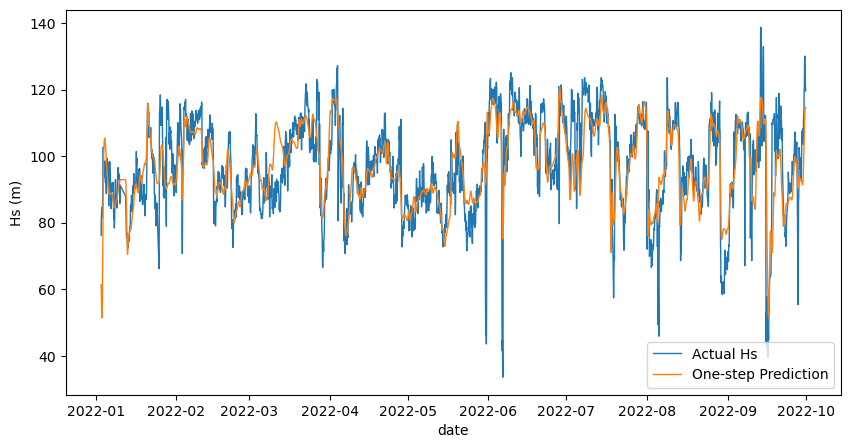

In [311]:
fig = plt.figure(figsize = (10, 5))
plt.plot(plot_df['dp'], label='Actual Hs', linewidth=1)
plt.plot(plot_df['pred_dp'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('Hs (m)')
plt.legend(loc='lower right')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


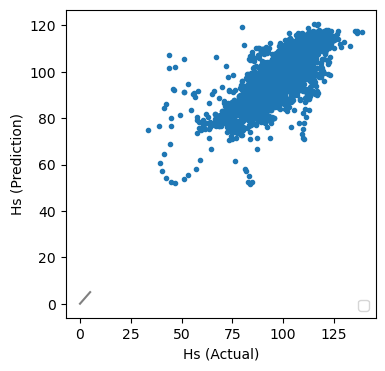

In [312]:
fig = plt.figure(figsize = (4, 4))
plt.plot([0,5], [0,5], color = 'grey')
plt.plot(plot_df['dp'].values, plot_df['pred_dp'], '.')
plt.xlabel('Hs (Actual)')
plt.ylabel('Hs (Prediction)')
plt.legend(loc='lower right')

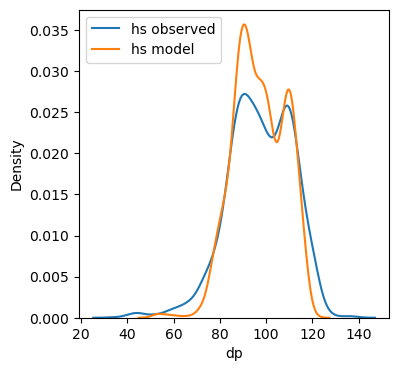

In [313]:
plt.figure(figsize=(4, 4))
sns.kdeplot(data=plot_df, x='dp', label='hs observed')
sns.kdeplot(data=plot_df, x='pred_dp', label='hs model')
plt.legend()

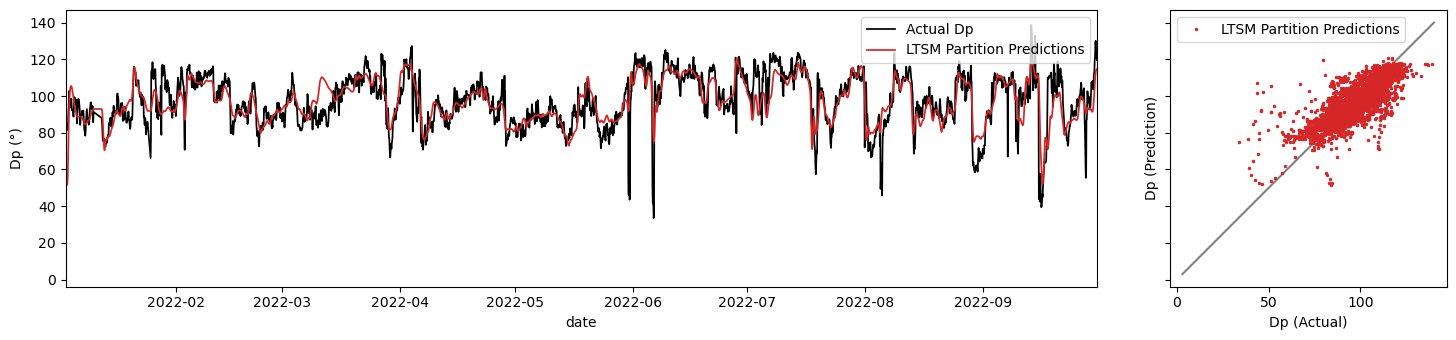

In [317]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3.5), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)  # Increase the width of the figure, adjust the width ratios, and share the y-axis

start = plot_df.loc['2022-01':].index[0]
end = ind_data.index[-1]

# Line timeseries plot
ax1.plot(plot_df['dp'], label='Actual Dp', linewidth=1.25, color = 'k')
ax1.plot(plot_df['pred_dp'], label='LTSM Partition Predictions', linewidth=1.25, color = 'tab:red')
ax1.set_xlabel('date')
ax1.set_ylabel('Dp (°)')
ax1.legend(loc='upper right')

# Scatter plot
ax2.plot([3, 140], [3, 140], color='grey')
ax2.plot(plot_df['dp'].values, plot_df['pred_dp'], '.', markersize=3, label='LTSM Partition Predictions', color = 'tab:red')
ax2.set_xlabel('Dp (Actual)')
ax2.set_ylabel('Dp (Prediction)')
ax2.legend(loc='upper left')
ax2.set_aspect('equal')  # Set aspect ratio to 'equal'

ax1.set_xlim(left=start, right=end)

plt.tight_layout()
#plt.savefig('./plots/independent_data_prediction_ltsm_part_tz.png', dpi=300, bbox_inches='tight')


In [193]:
plot_df.to_csv('../data/LSTM_part_predictions_dp.csv')

In [318]:
import cal_stats
cal_stats.all_stats(plot_df['pred_dp'].loc[start:].values, plot_df['dp'].loc[start:].values.flatten())

{'Bias': -0.43,
 'Root Mean Squared Error': 8.61,
 'Scatter Index': 8.8,
 'Coefficient of Determination': 0.62,
 'Coefficient of Efficiency': 0.62,
 'Correlation Coefficient': 0.79,
 'Index of Agreement': 0.87}

## Machine Learning (Sea and Swell Partitions)

In [347]:
from sklearn.neural_network import MLPRegressor
import pickle

In [348]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [362]:
features_col = ['hs','tp','tm02',
                'hs_sa', 'tm02_sa',
                'hs_sw','tm02_sw','dpm_sin','dm_sa_sin', 'dm_sw_sin']

#features_col = ['0.035', '0.0385', '0.042349998', '0.046585', '0.051243503',
#       '0.05636785', '0.062004633', '0.068205096', '0.07502561', '0.082528174',
#       '0.090780996', '0.099859096', '0.10984501', '0.120829515', '0.13291247',
#       '0.14620373', '0.1608241', '0.17690653', '0.19459718', '0.21405691',
#       '0.2354626', '0.25900885', '0.28490975', '0.31340075', '0.3447408',
#       '0.37921488', '0.4171364',  '0.45885003', '0.50473505', 'dm_sin', 'hour']

#features_col = ['hs','tp','tm02']

In [363]:
features = merged_df[features_col].values
labels = merged_df[labels_col].values

In [364]:
from sklearn.preprocessing import StandardScaler
#Train size: 80% of the total data size
train_size = int(len(features) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(features[:train_size + T - 1])
features = scaler.transform(features)

In [365]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle = False)

In [366]:
clf_mlp2 = MLPRegressor(hidden_layer_sizes = (6,6,6,6,6,6),
                                             activation = 'relu',
                                             solver = 'adam',
                                             shuffle = False,
                                             early_stopping = True,
                                             random_state = 0)

In [367]:
clf_mlp2.fit(X_train, y_train)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(6, 6, 6, 6, 6, 6),
             random_state=0, shuffle=False)

In [368]:
filename = 'dp_mlp_part.sav'
pickle.dump(clf_mlp2, open(filename, 'wb'))

In [369]:
#loaded_model = pickle.load(open(filename, 'rb'))

In [370]:
ind_data_clip = ind_data[features_col].dropna().copy()


#### Make Predictions

In [371]:
features_ind = scaler.transform(ind_data_clip.values)

In [372]:
clf_mlp2.predict(features_ind)

array([[ 0.99334282,  0.02156647],
       [ 0.99101757,  0.02747421],
       [ 0.99693288,  0.00644936],
       ...,
       [ 0.92246506, -0.35204866],
       [ 0.92353807, -0.34759778],
       [ 0.92458494, -0.34325529]])

In [373]:
part_pred = pd.DataFrame(clf_mlp2.predict(features_ind), index = ind_data_clip.index, columns = ['dp_sin','dp_cos'])
part_pred['dp_pred'] = part_pred.apply(lambda row: get_direction(row['dp_sin'], row['dp_cos']), axis=1)
part_pred['dp_tgt'] = ind_data.apply(lambda row: get_direction(row['dp_tgt_sin'], row['dp_tgt_cos']), axis=1)

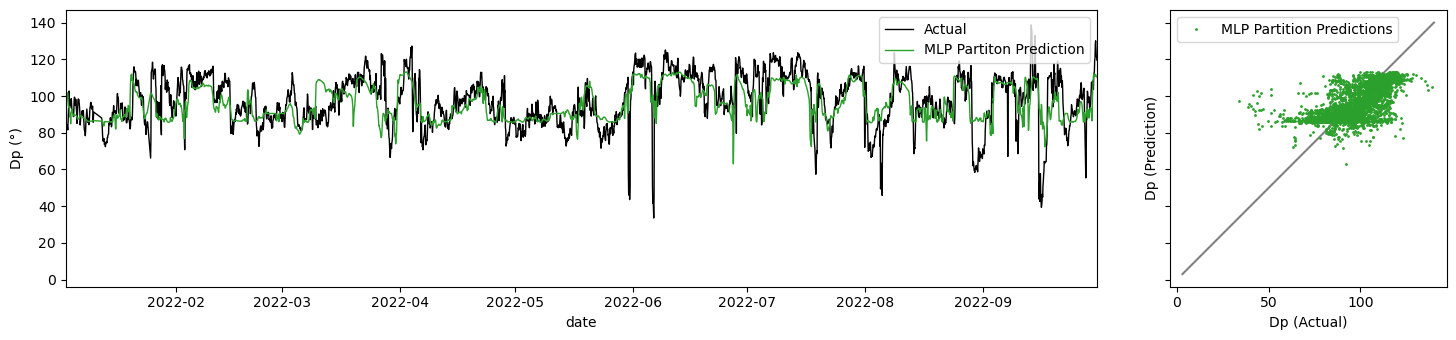

In [374]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3.5), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)  # Increase the width of the figure, adjust the width ratios, and share the y-axis


start = part_pred.loc[start:].index[0]
end = ind_data.index[-1]

# Line timeseries plot
ax1.plot(part_pred['dp_tgt'].loc[start:], label='Actual', linewidth=1, color = 'k')
ax1.plot(part_pred['dp_pred'].loc[start:], label='MLP Partiton Prediction', linewidth=1, color = 'tab:green')
ax1.set_xlabel('date')
ax1.set_ylabel('Dp (°)')
ax1.legend(loc='upper right')

# Scatter plot
ax2.plot([3, 140], [3, 140], color='grey')
ax2.plot(part_pred['dp_tgt'].loc[start:].values, part_pred['dp_pred'].loc[start:], '.', markersize=2, label='MLP Partition Predictions', color = 'tab:green')
ax2.set_xlabel('Dp (Actual)')
ax2.set_ylabel('Dp (Prediction)')
ax2.legend(loc='upper left')
ax2.set_aspect('equal')  # Set aspect ratio to 'equal'

ax1.set_xlim(left=start, right=end)

plt.tight_layout()
#plt.savefig('./plots/independent_data_prediction_mlp_part_tz.png', dpi=300, bbox_inches='tight')

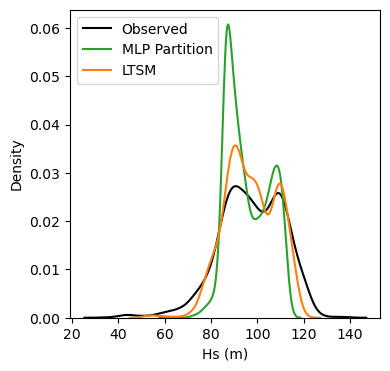

In [377]:
fig = plt.figure(figsize = (4, 4))
sns.kdeplot(data=part_pred.loc[start:], x='dp_tgt', label='Observed', color = 'k')
sns.kdeplot(data=part_pred, x='dp_pred', label='MLP Partition',  color = 'tab:green')
sns.kdeplot(data=plot_df, x='pred_dp', label='LTSM',  color = 'tab:orange')
plt.xlabel('Hs (m)')
plt.legend()

In [379]:
cal_stats.all_stats(part_pred['dp_pred'].loc[start:].values.flatten(), part_pred['dp_tgt'].loc[start:].values.flatten())

{'Bias': -1.6,
 'Root Mean Squared Error': 10.96,
 'Scatter Index': 11.1,
 'Coefficient of Determination': 0.39,
 'Coefficient of Efficiency': 0.38,
 'Correlation Coefficient': 0.63,
 'Index of Agreement': 0.75}

## Machine Learning Bulk Parameters

In [380]:
features_col = ['hs','tp','tm02', 'dpm_sin','dm_sin']

In [381]:
features = merged_df[features_col].values
labels = merged_df[labels_col].values

In [382]:
from sklearn.preprocessing import StandardScaler
#Train size: 80% of the total data size
train_size = int(len(features) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(features[:train_size + T - 1])
features = scaler.transform(features)

In [383]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle = False)

In [384]:
clf_mlp1 = MLPRegressor(hidden_layer_sizes = (6,6,6,6,6,6),
                                             activation = 'relu',
                                             solver = 'adam',
                                             shuffle = False,
                                             early_stopping = True,
                                             random_state = 0)

In [386]:
clf_mlp1.fit(X_train, y_train)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(6, 6, 6, 6, 6, 6),
             random_state=0, shuffle=False)

In [387]:
filename = 'dp_mlp.sav'
pickle.dump(clf_mlp1, open(filename, 'wb'))

In [388]:
clf_mlp1 = pickle.load(open(filename, 'rb'))

In [389]:
ind_data_clip = ind_data[features_col].dropna().copy()


#### Make Predictions

In [390]:
features_ind = scaler.transform(ind_data_clip.values)

In [391]:
clf_mlp1.predict(features_ind)

array([[ 9.83533804e-01,  2.28185729e-02],
       [ 9.85286150e-01,  2.46934882e-02],
       [ 9.87093454e-01,  7.90527690e-04],
       ...,
       [ 9.22563341e-01, -3.32305358e-01],
       [ 9.22041363e-01, -3.31549531e-01],
       [ 9.22899660e-01, -3.25285820e-01]])

In [392]:
_pred = pd.DataFrame(clf_mlp1.predict(features_ind), index = ind_data_clip.index, columns = ['dp_sin','dp_cos'])
_pred['dp_pred'] = _pred.apply(lambda row: get_direction(row['dp_sin'], row['dp_cos']), axis=1)
_pred['dp_tgt'] = ind_data.apply(lambda row: get_direction(row['dp_tgt_sin'], row['dp_tgt_cos']), axis=1)

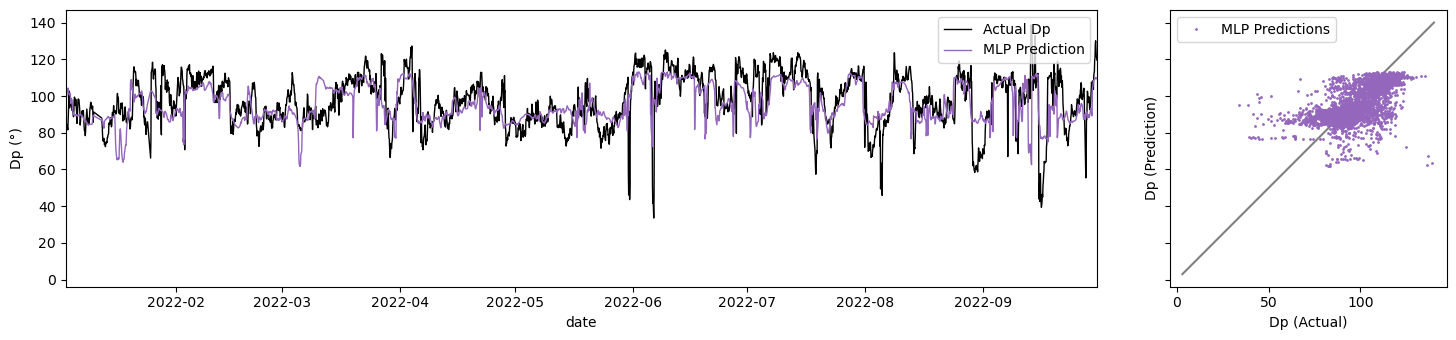

In [395]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3.5), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)  # Increase the width of the figure, adjust the width ratios, and share the y-axis


start = _pred.loc[start:].index[0]
end = ind_data.index[-1]

# Line timeseries plot
ax1.plot(_pred['dp_tgt'].loc[start:], label='Actual Dp', linewidth=1, color = 'k')
ax1.plot(_pred['dp_pred'].loc[start:], label='MLP Prediction', linewidth=1, color = 'tab:purple')
#ax1.plot(part_pred.loc[start:], label='MLP Partiton Prediction', linewidth=1, color = 'tab:green')
ax1.set_xlabel('date')
ax1.set_ylabel('Dp (°)')
ax1.legend(loc='upper right')

# Scatter plot
ax2.plot([3, 140], [3, 140], color='grey')
ax2.plot(_pred['dp_tgt'].loc[start:].values, _pred['dp_pred'].loc[start:], '.', markersize=2, label='MLP Predictions', color = 'tab:purple')
ax2.set_xlabel('Dp (Actual)')
ax2.set_ylabel('Dp (Prediction)')
ax2.legend(loc='upper left')
ax2.set_aspect('equal')  # Set aspect ratio to 'equal'

ax1.set_xlim(left=start, right=end)

plt.tight_layout()
plt.savefig('./plots/independent_data_prediction_mlp_dp.png', dpi=300, bbox_inches='tight')

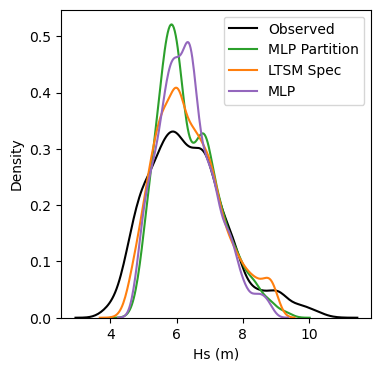

In [274]:
fig = plt.figure(figsize = (4, 4))
sns.kdeplot(data=ind_data.loc[start:], x='tz_tgt', label='Observed', color = 'k')
sns.kdeplot(data=part_pred, x='hs', label='MLP Partition',  color = 'tab:green')
sns.kdeplot(data=plot_df, x='prediction', label='LTSM Spec',  color = 'tab:orange')
sns.kdeplot(data=_pred, x='hs', label='MLP',  color = 'tab:purple')
plt.xlabel('Hs (m)')
plt.legend()

In [396]:
import cal_stats

In [399]:
cal_stats.all_stats(_pred['dp_pred'].loc[start:].values.flatten(), _pred['dp_tgt'].loc[start:].values.flatten())

{'Bias': -2.01,
 'Root Mean Squared Error': 11.5,
 'Scatter Index': 11.6,
 'Coefficient of Determination': 0.35,
 'Coefficient of Efficiency': 0.32,
 'Correlation Coefficient': 0.59,
 'Index of Agreement': 0.74}

# MLP Spec

In [400]:
features_col = ['0.035', '0.0385', '0.042349998', '0.046585', '0.051243503',
       '0.05636785', '0.062004633', '0.068205096', '0.07502561', '0.082528174',
       '0.090780996', '0.099859096', '0.10984501', '0.120829515', '0.13291247',
       '0.14620373', '0.1608241', '0.17690653', '0.19459718', '0.21405691',
       '0.2354626', '0.25900885', '0.28490975', '0.31340075', '0.3447408',
       '0.37921488', '0.4171364',  '0.45885003', '0.50473505', 'dm_sin', 'hour', 'dpm_sin']

#features_col = ['hs','tp','tm02']

In [401]:
features = merged_df[features_col].values
labels = merged_df[labels_col].values

In [402]:
from sklearn.preprocessing import StandardScaler
#Train size: 80% of the total data size
train_size = int(len(features) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(features[:train_size + T - 1])
features = scaler.transform(features)

In [403]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle = False)

In [404]:
clf_mlp3 = MLPRegressor(hidden_layer_sizes = (6,6,6,6,6,6),
                                             activation = 'relu',
                                             solver = 'adam',
                                             shuffle = False,
                                             early_stopping = True,
                                             random_state = 0)

In [406]:
clf_mlp3.fit(X_train, y_train)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(6, 6, 6, 6, 6, 6),
             random_state=0, shuffle=False)

In [407]:
filename = 'dp_mlp_spec.sav'
pickle.dump(clf_mlp3, open(filename, 'wb'))

In [408]:
#loaded_model = pickle.load(open(filename, 'rb'))

In [409]:
ind_data_clip = ind_data[features_col].dropna().copy()


#### Make Predictions

In [410]:
features_ind = scaler.transform(ind_data_clip.values)

In [411]:
clf_mlp3.predict(features_ind)

array([[ 0.97775888,  0.05199466],
       [ 0.97770821,  0.05920095],
       [ 0.97773568,  0.05529405],
       ...,
       [ 0.9240086 , -0.35576725],
       [ 0.92375569, -0.35696158],
       [ 0.92354386, -0.35796193]])

In [412]:
spec_pred = pd.DataFrame(clf_mlp3.predict(features_ind), index = ind_data_clip.index, columns = ['dp_sin','dp_cos'])
spec_pred['dp_pred'] = spec_pred.apply(lambda row: get_direction(row['dp_sin'], row['dp_cos']), axis=1)
spec_pred['dp_tgt'] = ind_data.apply(lambda row: get_direction(row['dp_tgt_sin'], row['dp_tgt_cos']), axis=1)

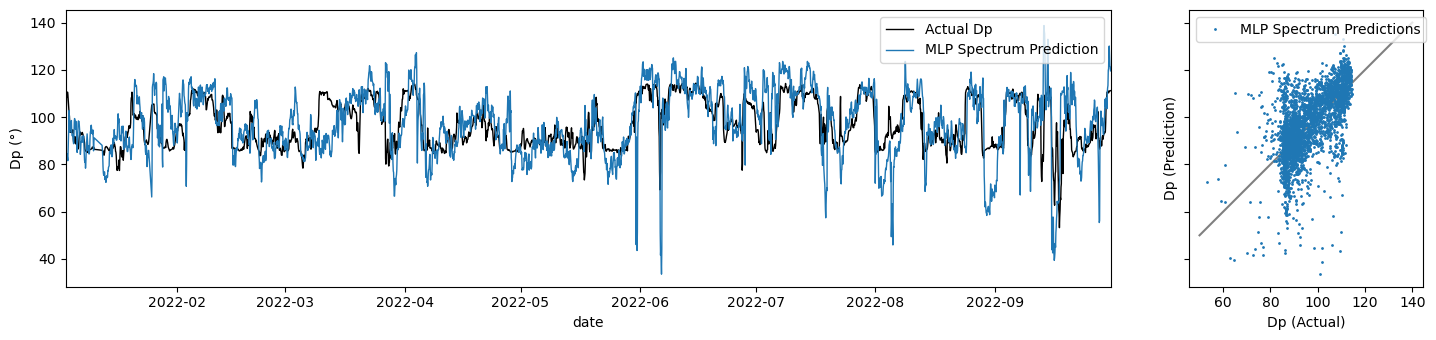

In [416]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3.5), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)  # Increase the width of the figure, adjust the width ratios, and share the y-axis


start = spec_pred.loc[start:].index[0]
end = ind_data.index[-1]

# Line timeseries plot
ax1.plot(spec_pred['dp_pred'].loc[start:], label='Actual Dp', linewidth=1, color = 'k')
ax1.plot(spec_pred['dp_tgt'].loc[start:], label='MLP Spectrum Prediction', linewidth=1, color = 'tab:blue')
ax1.set_xlabel('date')
ax1.set_ylabel('Dp (°)')
ax1.legend(loc='upper right')

# Scatter plot
ax2.plot([50, 140], [50, 140], color='grey')
ax2.plot(spec_pred['dp_pred'].loc[start:].values, spec_pred['dp_tgt'].loc[start:], '.', markersize=2, label='MLP Spectrum Predictions', color = 'tab:blue')
ax2.set_xlabel('Dp (Actual)')
ax2.set_ylabel('Dp (Prediction)')
ax2.legend(loc='upper left')
ax2.set_aspect('equal')  # Set aspect ratio to 'equal'

ax1.set_xlim(left=start, right=end)

plt.tight_layout()
#plt.savefig('./plots/independent_data_prediction_mlp_spec.png', dpi=300, bbox_inches='tight')

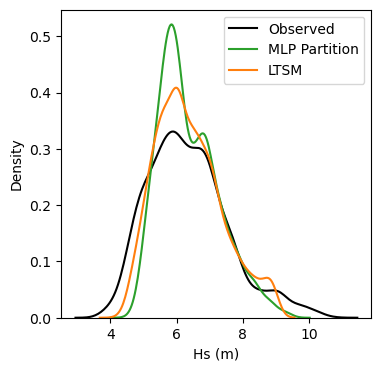

In [292]:
fig = plt.figure(figsize = (4, 4))
sns.kdeplot(data=ind_data.loc[start:], x='tz_tgt', label='Observed', color = 'k')
sns.kdeplot(data=part_pred, x='hs', label='MLP Partition',  color = 'tab:green')
sns.kdeplot(data=plot_df, x='prediction', label='LTSM',  color = 'tab:orange')
plt.xlabel('Hs (m)')
plt.legend()

In [415]:
cal_stats.all_stats(spec_pred['dp_pred'].loc[start:].values.flatten(), spec_pred['dp_tgt'].loc[start:].values.flatten())

{'Bias': -0.72,
 'Root Mean Squared Error': 11.02,
 'Scatter Index': 11.3,
 'Coefficient of Determination': 0.38,
 'Coefficient of Efficiency': 0.37,
 'Correlation Coefficient': 0.62,
 'Index of Agreement': 0.76}

# Compare to a simple xboost model

In [ ]:
import xgboost as xgb

In [ ]:
features.shape

(17369, 34)

In [ ]:
labels.shape

(17369, 1)

In [ ]:
# Define the model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)

train_X, test_X = features[:train_size], features[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

# Fit the model
model.fit(train_X, train_y, eval_set=[(test_X, test_y)], verbose=False)

# Make predictions
predictions = model.predict(test_X)


In [ ]:
plot_len = len(predictions)
plot_df = merged_df[labels_col].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = predictions
plot_df.head(5)

,hs_tgt,prediction
2017-03-16 23:00:00,1.71,1.036096
2017-03-17 03:00:00,1.38,1.189543
2017-03-17 08:00:00,1.46,1.121853
2017-03-17 12:00:00,1.38,1.009145
2017-03-17 17:00:00,1.39,1.142602


Text(0, 0.5, 'Hs (m)')

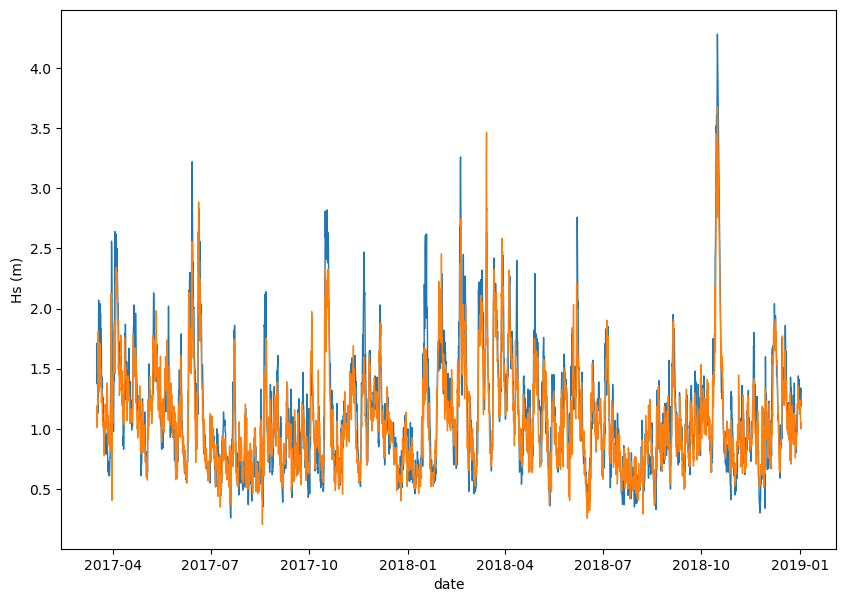

In [ ]:
fig = plt.figure(figsize = (10, 7))
plt.plot(plot_df[labels_col], label='Actual Hs', linewidth=1)
plt.plot(pd.DataFrame(predictions, index = plot_df.index), label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('Hs (m)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


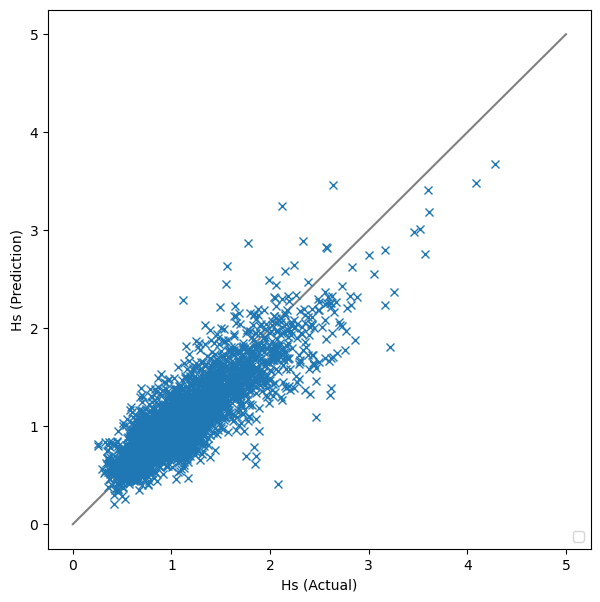

In [ ]:
fig = plt.figure(figsize = (7, 7))
plt.plot([0,5], [0,5], color = 'grey')
plt.plot(plot_df[labels_col].values, plot_df['prediction'], 'x')
plt.xlabel('Hs (Actual)')
plt.ylabel('Hs (Prediction)')
plt.legend(loc='lower right')

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot

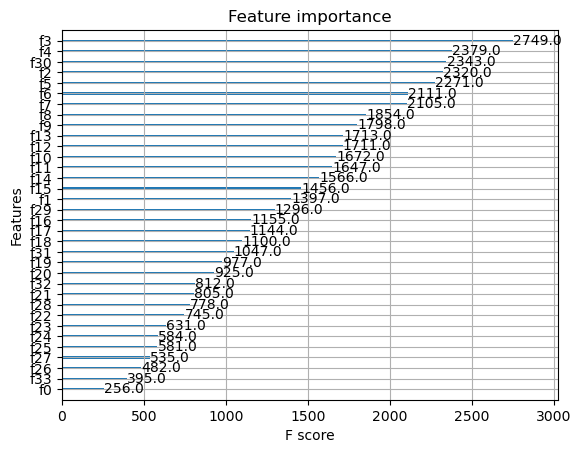

In [ ]:
plot_importance(model)
pyplot.show()

In [ ]:
cal_stats.all_stats(plot_df['prediction'].values, plot_df[labels_col].values.flatten())

{'Bias': -0.05,
 'Root Mean Squared Error': 0.25,
 'Scatter Index': 22.1,
 'Coefficient of Determination': 0.74,
 'Coefficient of Efficiency': 0.73,
 'Correlation Coefficient': 0.86,
 'Index of Agreement': 0.92}